In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas import Series
import requests
import json
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

In [103]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')

# Adding weighted price

data['Weighted_Price'] = (data.close + data.high + data.low + data.open)/4

In [105]:
data.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-16,7874.11,8352.25,7679.05,8183.83,95341.68,7.621041e+08,8022.3100
2019-05-17,7371.96,7930.98,6668.67,7874.11,141482.93,1.023962e+09,7461.4300
2019-05-18,7266.08,7491.67,7213.72,7371.96,41327.89,3.033175e+08,7335.8575
2019-05-19,8193.14,8281.66,7257.26,7266.08,91218.12,7.230112e+08,7749.5350
2019-05-20,7793.41,8193.14,7591.85,8193.14,60979.38,4.813355e+08,7942.8850


In [106]:
print(f'NaN values: \n\n{data.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


In [107]:
values = data['Weighted_Price'].values.reshape(-1,1)
print(values[0])
values = values.astype('float32')
print(values[0])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Get the type of the new item scaled
print(type(scaled))

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1014.725]
[1014.725]
<class 'numpy.ndarray'>
Length of the new datframe : 2001
[[0.04680875]
 [0.05175803]
 [0.05387902]
 [0.05643262]
 [0.04952902]]


In [108]:
train_size = int(len(scaled) * 0.7)
print("Train Size : " + str(train_size))
test_size = len(scaled) - train_size
print("Test Size : " + str(test_size))
# print(scaled[0,])
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1400
Test Size : 601
Length of training data : 1400
Length of testing data : 601


In [109]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [110]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1399, 1)
(1399,)
(600, 1)
(600,)


In [111]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1399, 1, 1)
(600, 1, 1)


In [112]:
print(trainX)
print(trainY)

[[[0.04680875]]

 [[0.05175803]]

 [[0.05387902]]

 ...

 [[0.1866562 ]]

 [[0.18815687]]

 [[0.19282272]]]
[0.05175803 0.05387902 0.05643262 ... 0.18815687 0.19282272 0.19842719]


In [150]:
# Initialise the sequential model
model = Sequential()
# Add the LSTM hidden layer with 100 units
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
# Add the output layer
model.add(Dense(1))
# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')
# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 1399 samples, validate on 600 samples
Epoch 1/300
1399/1399 [==============================] - 2s 1ms/step - loss: 0.0247 - acc: 7.1480e-04 - val_loss: 0.3214 - val_acc: 0.0000e+00
Epoch 2/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0237 - acc: 7.1480e-04 - val_loss: 0.3116 - val_acc: 0.0000e+00
Epoch 3/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0229 - acc: 7.1480e-04 - val_loss: 0.3063 - val_acc: 0.0000e+00
Epoch 4/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0220 - acc: 7.1480e-04 - val_loss: 0.2993 - val_acc: 0.0000e+00
Epoch 5/300
1399/1399 [==============================] - 0s 32us/step - loss: 0.0213 - acc: 7.1480e-04 - val_loss: 0.2900 - val_acc: 0.0000e+00
Epoch 6/300
1399/1399 [==============================] - 0s 34us/step - loss: 0.0207 - acc: 7.1480e-04 - val_loss: 0.2808 - val_acc: 0.0000e+00
Epoch 7/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0202 - acc

1399/1399 [==============================] - 0s 31us/step - loss: 0.0039 - acc: 7.1480e-04 - val_loss: 0.0190 - val_acc: 0.0017
Epoch 59/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0019 - acc: 7.1480e-04 - val_loss: 0.0177 - val_acc: 0.0017
Epoch 60/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0012 - acc: 7.1480e-04 - val_loss: 0.0148 - val_acc: 0.0017
Epoch 61/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0012 - acc: 7.1480e-04 - val_loss: 0.0165 - val_acc: 0.0017
Epoch 62/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0021 - acc: 7.1480e-04 - val_loss: 0.0120 - val_acc: 0.0017
Epoch 63/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0019 - acc: 7.1480e-04 - val_loss: 0.0114 - val_acc: 0.0017
Epoch 64/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0027 - acc: 7.1480e-04 - val_loss: 0.0115 - val_acc: 0.0017
Epoch 65/300
1399/1399 [==

1399/1399 [==============================] - 0s 31us/step - loss: 0.0021 - acc: 7.1480e-04 - val_loss: 0.0269 - val_acc: 0.0017
Epoch 117/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0014 - acc: 7.1480e-04 - val_loss: 0.0172 - val_acc: 0.0017
Epoch 118/300
1399/1399 [==============================] - 0s 27us/step - loss: 0.0015 - acc: 7.1480e-04 - val_loss: 0.0126 - val_acc: 0.0017
Epoch 119/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0014 - acc: 7.1480e-04 - val_loss: 0.0127 - val_acc: 0.0017
Epoch 120/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0014 - acc: 7.1480e-04 - val_loss: 0.0138 - val_acc: 0.0017
Epoch 121/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0011 - acc: 7.1480e-04 - val_loss: 0.0165 - val_acc: 0.0017
Epoch 122/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0015 - acc: 7.1480e-04 - val_loss: 0.0120 - val_acc: 0.0017
Epoch 123/300
1399/1

Epoch 174/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0037 - acc: 7.1480e-04 - val_loss: 0.0172 - val_acc: 0.0017
Epoch 175/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0016 - acc: 7.1480e-04 - val_loss: 0.0201 - val_acc: 0.0017
Epoch 176/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0017 - acc: 7.1480e-04 - val_loss: 0.0166 - val_acc: 0.0017
Epoch 177/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0014 - acc: 7.1480e-04 - val_loss: 0.0150 - val_acc: 0.0017
Epoch 178/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0011 - acc: 7.1480e-04 - val_loss: 0.0163 - val_acc: 0.0017
Epoch 179/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0017 - acc: 7.1480e-04 - val_loss: 0.0116 - val_acc: 0.0017
Epoch 180/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0016 - acc: 7.1480e-04 - val_loss: 0.0109 - val_acc: 0.0017
Epoch 

Epoch 232/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0013 - acc: 7.1480e-04 - val_loss: 0.0141 - val_acc: 0.0017
Epoch 233/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0023 - acc: 7.1480e-04 - val_loss: 0.0116 - val_acc: 0.0017
Epoch 234/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0045 - acc: 7.1480e-04 - val_loss: 0.0111 - val_acc: 0.0017
Epoch 235/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0018 - acc: 7.1480e-04 - val_loss: 0.0212 - val_acc: 0.0017
Epoch 236/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0011 - acc: 7.1480e-04 - val_loss: 0.0143 - val_acc: 0.0017
Epoch 237/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0012 - acc: 7.1480e-04 - val_loss: 0.0123 - val_acc: 0.0017
Epoch 238/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0028 - acc: 7.1480e-04 - val_loss: 0.0149 - val_acc: 0.0017
Epoch 

Epoch 290/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0032 - acc: 7.1480e-04 - val_loss: 0.0102 - val_acc: 0.0017
Epoch 291/300
1399/1399 [==============================] - 0s 29us/step - loss: 0.0035 - acc: 7.1480e-04 - val_loss: 0.0159 - val_acc: 0.0017
Epoch 292/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0013 - acc: 7.1480e-04 - val_loss: 0.0204 - val_acc: 0.0017
Epoch 293/300
1399/1399 [==============================] - 0s 28us/step - loss: 0.0018 - acc: 7.1480e-04 - val_loss: 0.0174 - val_acc: 0.0017
Epoch 294/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0013 - acc: 7.1480e-04 - val_loss: 0.0181 - val_acc: 0.0017
Epoch 295/300
1399/1399 [==============================] - 0s 31us/step - loss: 0.0012 - acc: 7.1480e-04 - val_loss: 0.0129 - val_acc: 0.0017
Epoch 296/300
1399/1399 [==============================] - 0s 30us/step - loss: 0.0014 - acc: 7.1480e-04 - val_loss: 0.0104 - val_acc: 0.0017
Epoch 

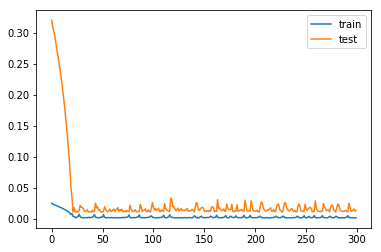

In [116]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

(600, 1)
[0.20695814]


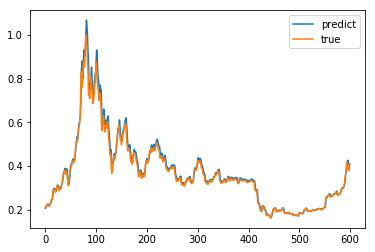

In [117]:
yhat = model.predict(testX) # Here yhat is the predicted value from the test set (y_pred)
print(yhat.shape)
print(yhat[0])

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [118]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(600, 1)
(600, 1)
[4079.9268]
[4198.8423]


In [124]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 442.882


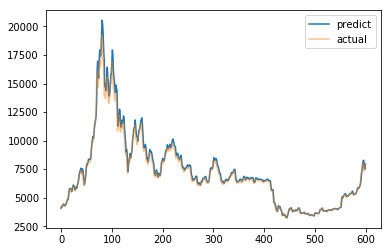

In [120]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

# Nedenunder er sjov og ballade - det har ikke ført til det ønskede og bør bare ignoreres for nu!

In [161]:
data.index[-10:]

DatetimeIndex(['2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14',
               '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18',
               '2019-05-19', '2019-05-20'],
              dtype='datetime64[ns]', name='time', freq=None)

In [177]:
dates = ['2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14',
               '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18',
               '2019-05-19', '2019-05-20']

future_dates = pd.DataFrame(dates, columns=['time'])
future_dates = future_dates.set_index('time')
future_dates['Weighted_Price'] = 0
future_dates = scaler.fit_transform(future_dates)

/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [178]:
future_datesX, future_datesY = create_dataset(future_dates, look_back)

In [179]:
future_dates = np.reshape(future_dates, (future_dates.shape[0], 1, future_dates.shape[1]))

In [180]:
future = model.predict(future_dates)

In [182]:
future = scaler.inverse_transform(future.reshape(-1, 1))

print(future.shape)

print(future[0])

(10, 1)
[0.0031987]
